In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

# Importing Necessary Libraries:

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
%matplotlib inline

# Defining the parameters
batch_size = 32
num_classes = 6  # Since your dataset has 6 categories

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Train , Test , Pred Samples

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the paths to your dataset directories
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'  # Update with the path to your train dataset
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'    # Update with the path to your test dataset
pred_data_dir = '/kaggle/input/intel-image-classification/seg_pred'    # Update with the path to your prediction dataset

# Define the data generators for training, testing, and prediction
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values between 0 and 1

# Splitting the data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

pred_generator = datagen.flow_from_directory(
    pred_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode=None,  # Set class_mode to None for prediction data
    shuffle=False  # Set shuffle to False for prediction data
)

# Get the number of samples in each dataset
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples
num_pred_samples = pred_generator.samples

# Print the information about the datasets
print('Number of training samples:', num_train_samples)
print('Number of testing samples:', num_test_samples)
print('Number of prediction samples:', num_pred_samples)

# Splitting the data into inputs and labels
x_train, y_train = next(train_generator)
x_test, y_test = next(test_generator)
x_pred = next(pred_generator)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.
Number of training samples: 14034
Number of testing samples: 3000
Number of prediction samples: 7301


# Visualizing Intel Dataset 

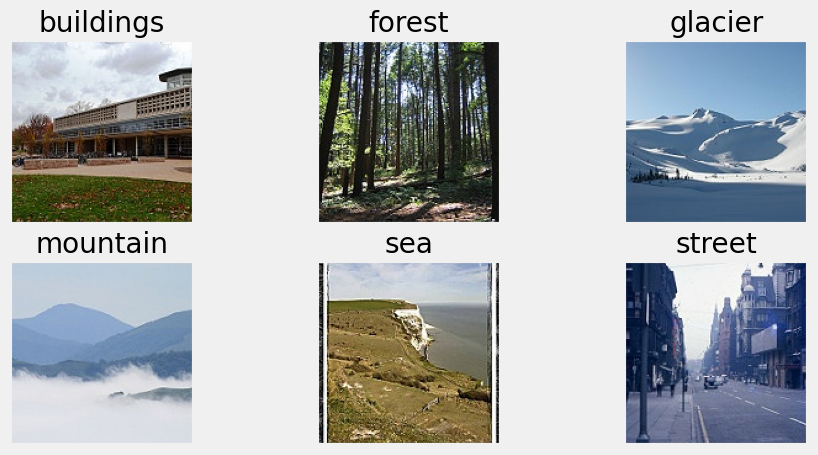

In [4]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

fig = plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    ax = fig.add_subplot(2, 3, 1 + i, xticks=[], yticks=[])
    class_dir = os.path.join(train_data_dir, class_names[i])
    img_filenames = os.listdir(class_dir)
    img_path = os.path.join(class_dir, img_filenames[0])
    im = plt.imread(img_path)
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

By performing this one-hot encoding step, the class labels will be represented as binary vectors, which is the expected format for multi-class classification tasks in TensorFlow.

In [5]:
# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Designing The Convolution Neural Network

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# Define the number of classes in your dataset
num_classes = 6

# Build the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Visualizing the Convolution Neural Network:

In [7]:
# Installing Visual Keras

!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 33.1 MB/s eta 0:00:00


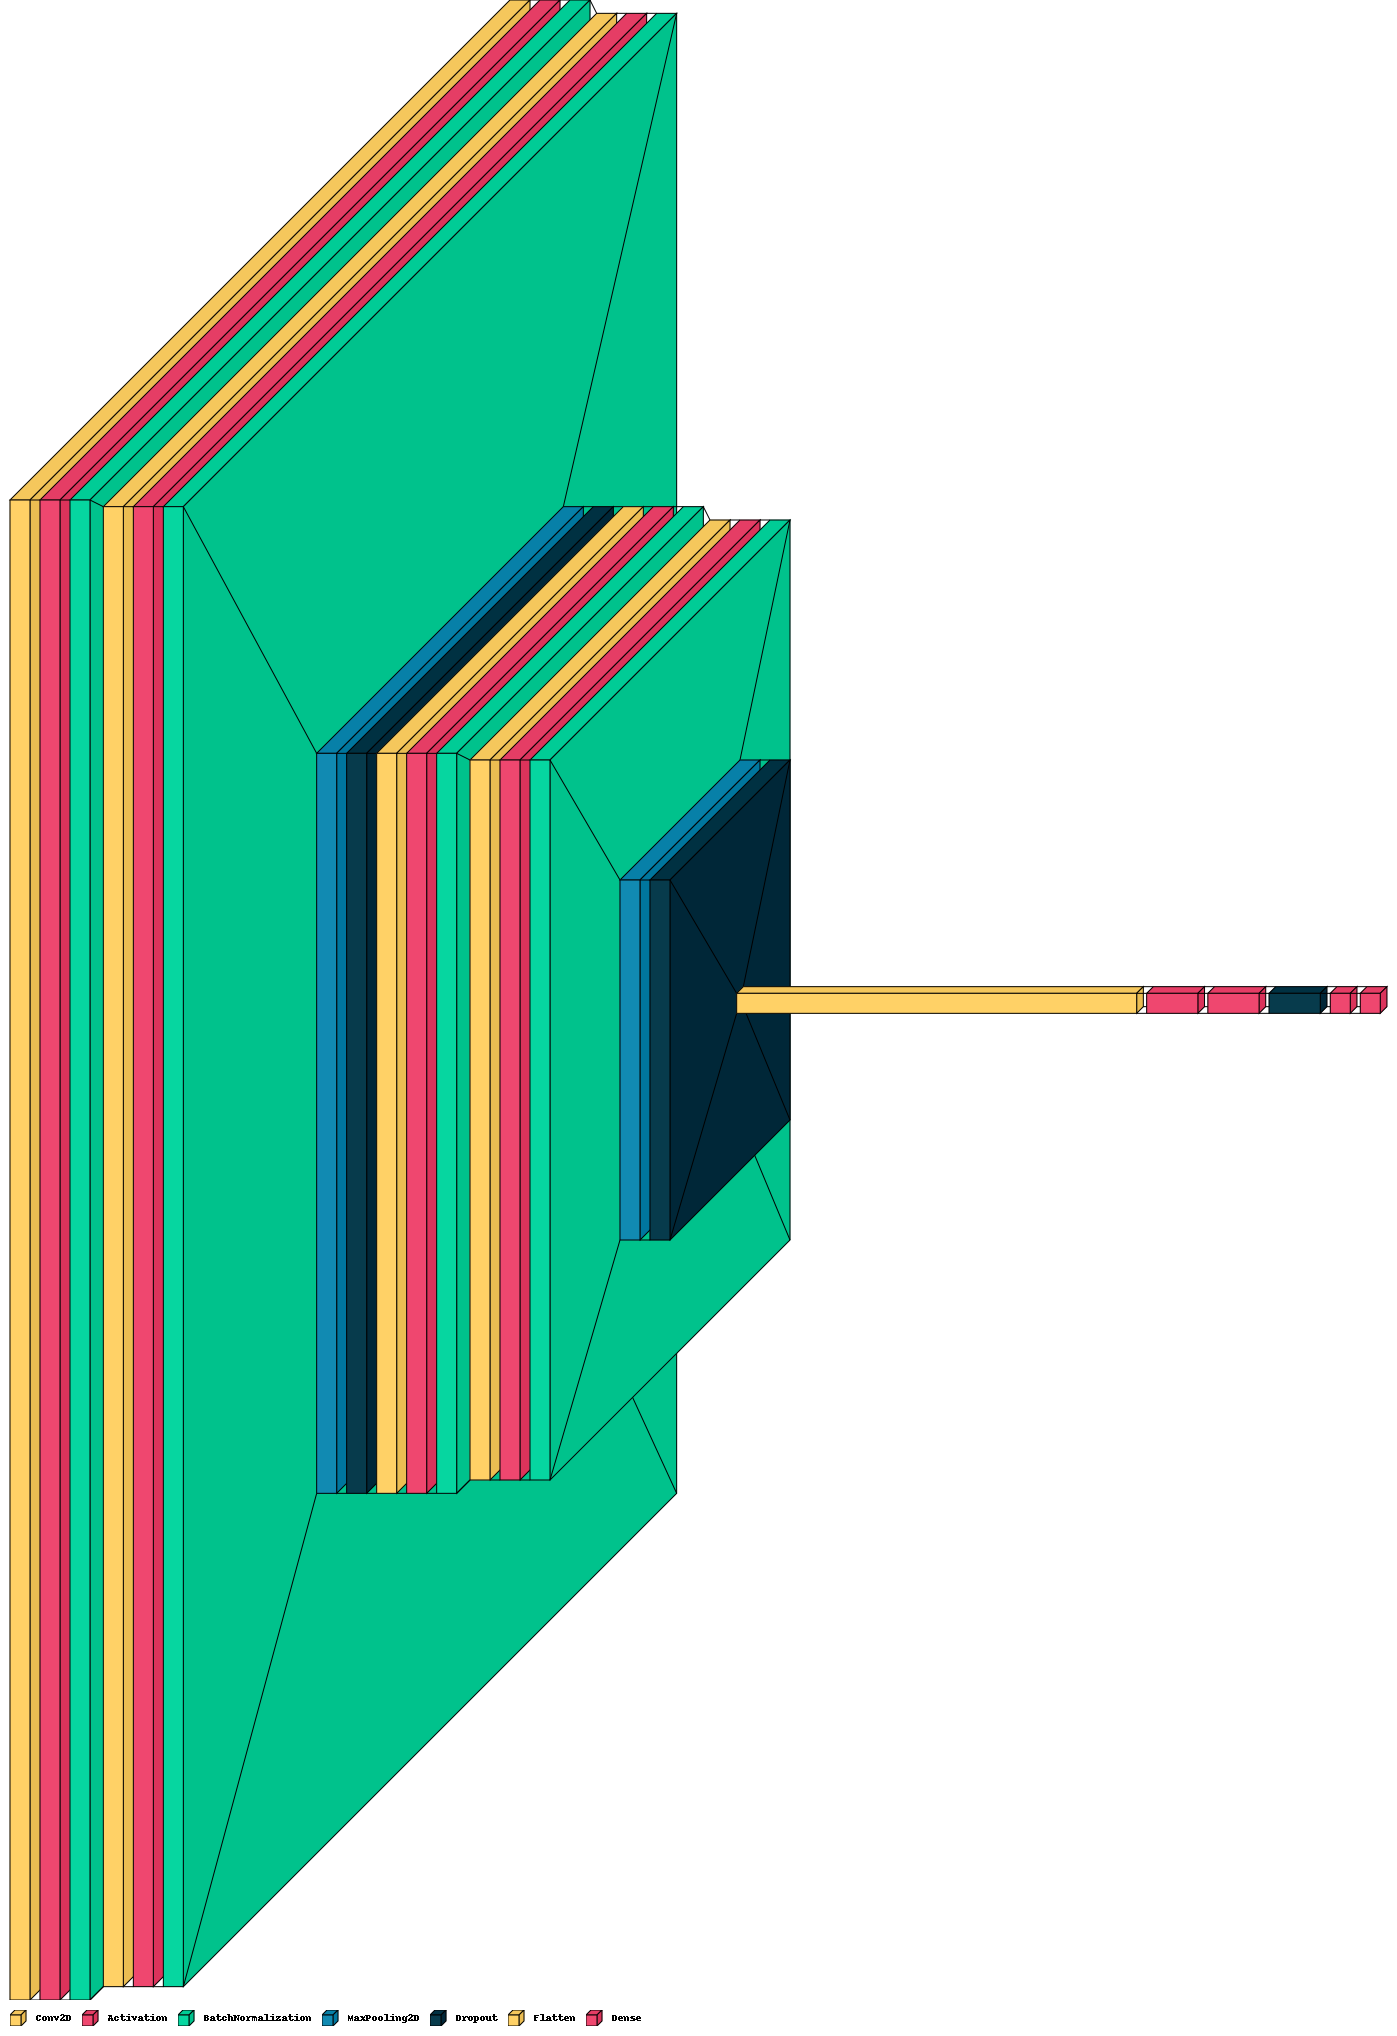

In [8]:
import visualkeras

# Visualize the model
visualkeras.layered_view(model, scale_xy=10, legend=True)

# Summary of the Convolution Neural Network 

In [9]:
# summary of the model (Hidden Input)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 activation (Activation)     (None, 150, 150, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 148, 148, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 148, 148, 64)     256       
 hNormalization)                                        

The model summary you provided shows the architecture of the model you have built. Here's a breakdown of the layers in your model:

Conv2D layer: It has 64 filters of size 3x3. The output shape is (150, 150, 64), and it has 1,792 parameters.

Activation layer: Applies the ReLU activation function to the output of the previous layer.

BatchNormalization layer: Normalizes the activations of the previous layer.

Conv2D layer: It has 64 filters of size 3x3. The output shape is (148, 148, 64), and it has 36,928 parameters.

Activation layer: Applies the ReLU activation function.

BatchNormalization layer: Normalizes the activations.

MaxPooling2D layer: Performs max pooling with a pool size of 2x2, reducing the spatial dimensions by half.

Dropout layer: Applies dropout with a rate of 0.25, randomly setting a fraction of input units to 0 at each update during training.

Conv2D layer: It has 128 filters of size 3x3. The output shape is (74, 74, 128), and it has 73,856 parameters.

Activation layer: Applies the ReLU activation function.

BatchNormalization layer: Normalizes the activations.

Conv2D layer: It has 128 filters of size 3x3. The output shape is (72, 72, 128), and it has 147,584 parameters.

Activation layer: Applies the ReLU activation function.

BatchNormalization layer: Normalizes the activations.

MaxPooling2D layer: Performs max pooling with a pool size of 2x2.

Dropout layer: Applies dropout with a rate of 0.25.

Flatten layer: Flattens the input from 3D to 1D.

Dense layer: Fully connected layer with 512 units. It has 84,935,168 parameters.

Activation layer: Applies the ReLU activation function.

Dropout layer: Applies dropout with a rate of 0.5.

Dense layer: Fully connected layer with 6 units (equal to the number of classes in your dataset). It has 3,078 parameters.

Activation layer: Applies the softmax activation function.

The model has a total of 85,199,942 parameters, out of which 85,199,174 are trainable parameters. The model summary also indicates the output shape of each layer.

Overall, this model is a convolutional neural network (CNN) with multiple convolutional, activation, batch normalization, pooling, dropout, and dense layers. It is designed for image classification with 6 classes.

# Compiling and Training the Model 

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

epochs = 50

# Training the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    shuffle=True)

Epoch 1/50


2023-06-11 14:57:36.382853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


439/439 [==============================] - 108s 226ms/step - loss: 12.1148 - accuracy: 0.5027 - val_loss: 10.7036 - val_accuracy: 0.5033
Epoch 2/50
439/439 [==============================] - 48s 110ms/step - loss: 9.1394 - accuracy: 0.6396 - val_loss: 8.5540 - val_accuracy: 0.6693
Epoch 3/50
439/439 [==============================] - 49s 111ms/step - loss: 7.7169 - accuracy: 0.7069 - val_loss: 7.3014 - val_accuracy: 0.7227
Epoch 4/50
439/439 [==============================] - 50s 113ms/step - loss: 6.5447 - accuracy: 0.7449 - val_loss: 6.1908 - val_accuracy: 0.7393
Epoch 5/50
439/439 [==============================] - 49s 111ms/step - loss: 5.5556 - accuracy: 0.7822 - val_loss: 5.3522 - val_accuracy: 0.7593
Epoch 6/50
439/439 [==============================] - 48s 109ms/step - loss: 4.7655 - accuracy: 0.7971 - val_loss: 4.5380 - val_accuracy: 0.7833
Epoch 7/50
439/439 [==============================] - 48s 109ms/step - loss: 4.0916 - accuracy: 0.8112 - val_loss: 3.9371 - val_accuracy: 

# Evaluating the Model

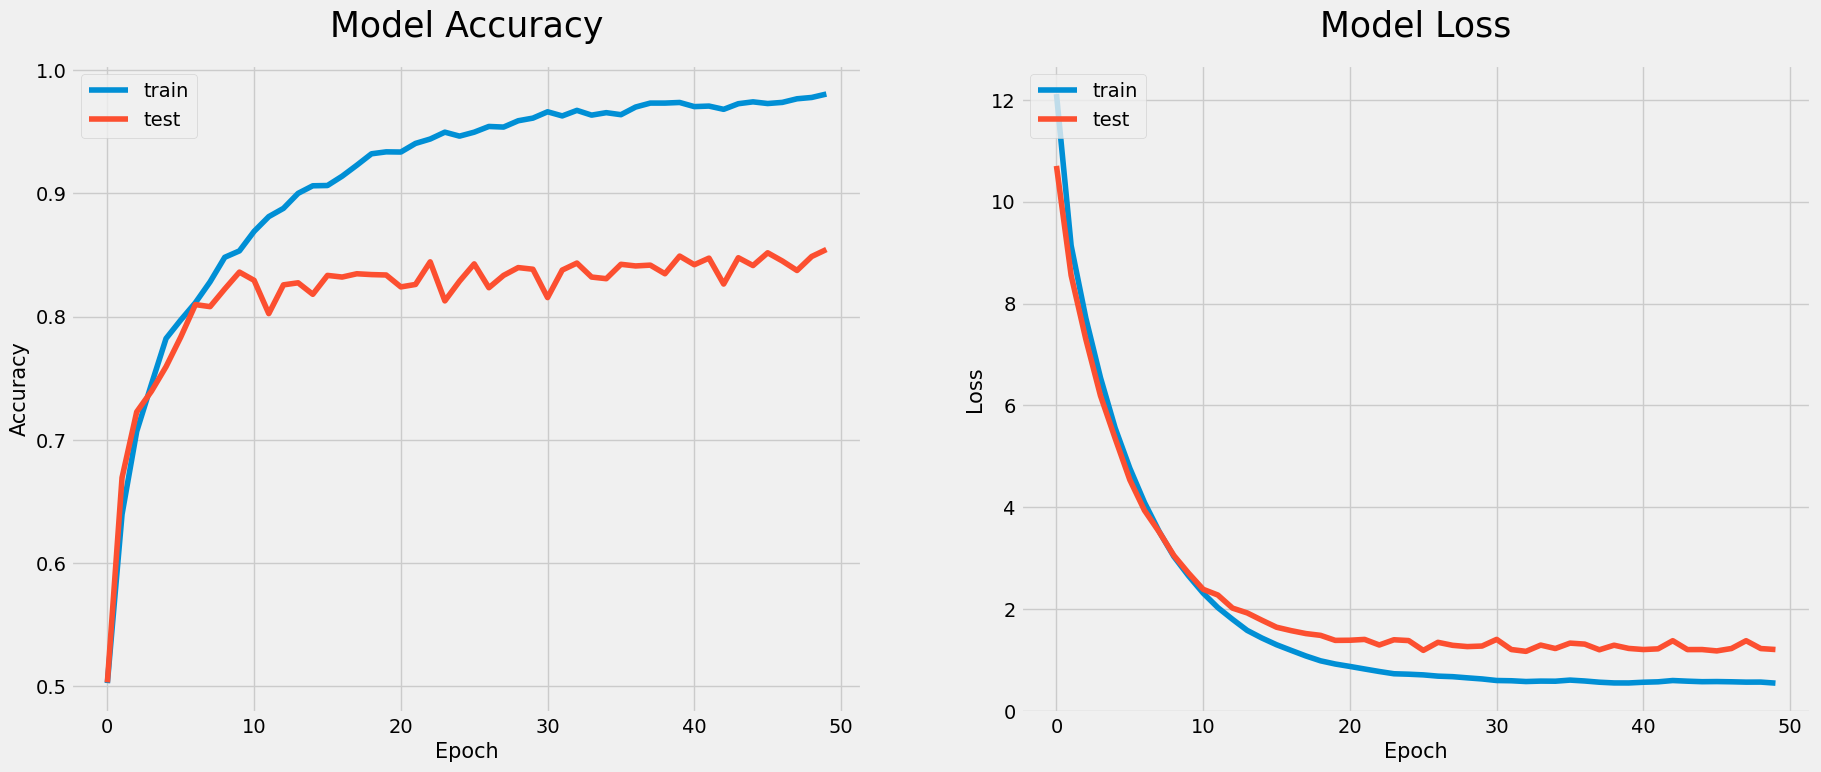

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 8])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

plt.show()


# Predictions Using the CNN Model 

1/1 [==============================] - 0s 169ms/step


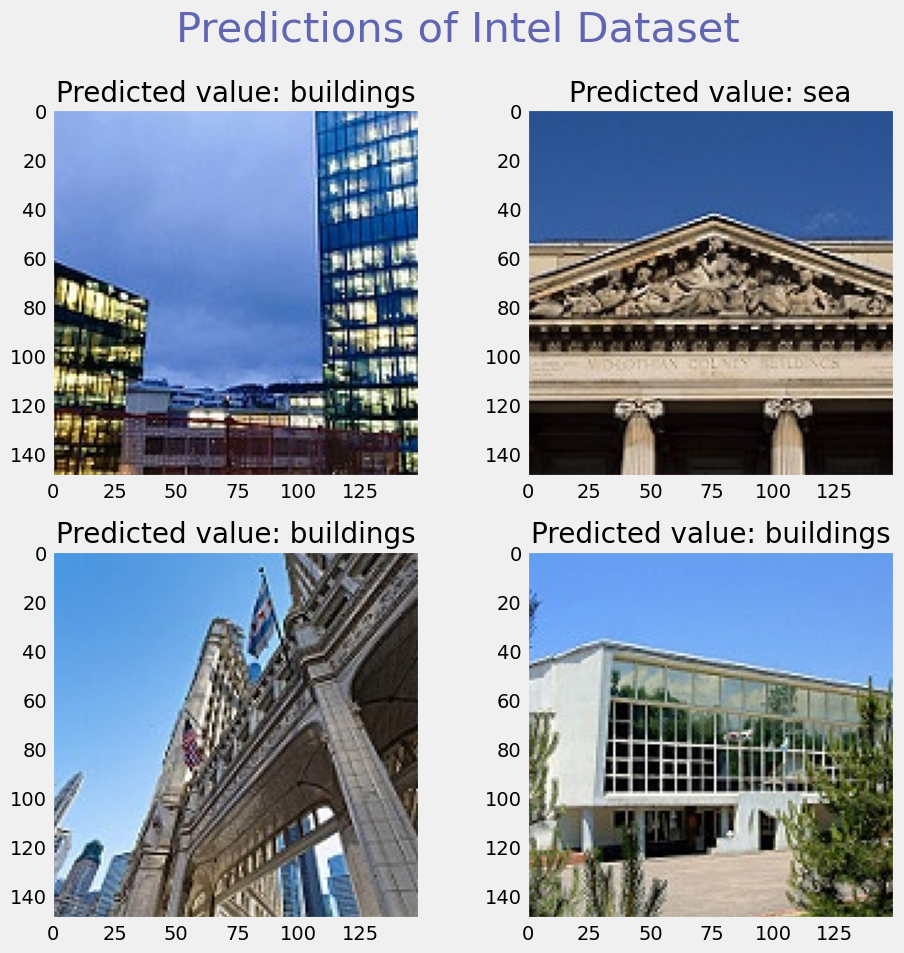

In [12]:
predictions = model.predict(x_test)

plt.figure(figsize=[10, 10])

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  # Replace with your class names

plt.subplot(2, 2, 1)
n = 3
plt.imshow(x_test[n].reshape(150, 150, -1), cmap=plt.cm.binary)  # Adjust the reshape dimensions if needed
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2, 2, 2)
n = 4
plt.imshow(x_test[n].reshape(150, 150, -1), cmap=plt.cm.binary)  # Adjust the reshape dimensions if needed
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2, 2, 3)
n = 8
plt.imshow(x_test[n].reshape(150, 150, -1), cmap=plt.cm.binary)  # Adjust the reshape dimensions if needed
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2, 2, 4)
n = 6
plt.imshow(x_test[n].reshape(150, 150, -1), cmap=plt.cm.binary)  # Adjust the reshape dimensions if needed
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.suptitle("Predictions of Intel Dataset", size=30, color="#6166B3")

plt.show()
